In [1]:
 ## all packages
 ! pip install gymnasium[all]
 !apt-get install git
 !git clone https://github.com/magni84/gym_RLcourse.git
 %cd gym_RLcourse
 !pip install -e .
 !pip install matplotlib
 !pip install pygame

 ! pip install gymnasium 'gymnasium[atari]' 'gymnasium[accept-rom-license]'

 import gymnasium as gym
 import gym_RLcourse
 import numpy as np
 import matplotlib
 import matplotlib.pyplot as plt
 from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

 from collections import namedtuple, deque
 from itertools import count
 import math
 import random

 ### Torch imports
 import torch
 # from torch import nn
 from torch.utils.data import DataLoader
 from torchvision import datasets
 from torchvision.transforms import ToTensor

 import torch.nn as nn
 import torch.nn.functional as F
 import argparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manyl

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import gym
import torch.nn.functional as F

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)

    def push(self, obs, action, next_obs, reward, donne):
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = (obs, action, reward, next_obs, donne)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Samples batch_size transitions from the replay memory and returns a tuple
            (obs, action, next_obs, reward)
        """
        sample = random.sample(self.memory, batch_size)
        return zip(*sample)

# Initialize environment and agent
env = gym.make('CartPole-v1')
# env = gym.wrappers.RecordVideo(env, './video/', episode_trigger=lambda episode_id: True)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n




CartPole = {
    'memory_size': 50000,
    'n_episodes': 1000,
    'batch_size': 32,
    'target_update_frequency': 100,
    'train_frequency': 1,
    'gamma': 0.95,
    'lr': 1e-4,
    'eps_start': 1.0,
    'eps_end': 0.05,
    'anneal_length': 10**4,
    'n_actions': 2,
    'epsilon': 0.9
}
ENV_CONFIGS = {
    'CartPole-v1': CartPole
}

env_config = ENV_CONFIGS['CartPole-v1']
replay_memory = ReplayMemory(env_config['memory_size'])


# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
    def forward(self, x):
        # print('x: ',x.shape)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_network = QNetwork(state_size, action_size).to(device)
target_network = QNetwork(state_size, action_size).to(device)
target_network.load_state_dict(q_network.state_dict())
target_network.eval()

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        #self.q_network = QNetwork(state_size, action_size).to(self.device)
        #self.target_network = QNetwork(state_size, action_size).to(self.device)
        #self.target_network.load_state_dict(self.q_network.state_dict())
        #self.target_network.eval()

        self.optimizer = optim.Adam(q_network.parameters(), lr=lr)
        self.loss_function = F.mse_loss

    def act(self, state, exploit = False):
       if exploit == False:
          if random.random() > self.epsilon:
              with torch.no_grad():
                  state = torch.FloatTensor(state).unsqueeze(0).to(device)
                  q_values = q_network(state)
                  action = q_values.argmax().item()
          else:
              action = random.randrange(self.action_size)
          return action
       else:
         with torch.no_grad():
                  state = torch.FloatTensor(state).unsqueeze(0).to(device)
                  q_values = q_network(state)
                  action = q_values.argmax().item()
                  return action


    def train(self, state, action, reward, next_state, done, batch_size=32, step = 1):
        if len(replay_memory) < batch_size:
            return

        # batch = random.sample(replay_memory, batch_size)
        # states, actions, rewards, next_states, dones = zip(*batch)
        states, actions, next_states, rewards, dones = replay_memory.sample(batch_size)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
        # print("states:", states.shape)
        # print("actions:", actions.shape)
        # print("rewards:", rewards.shape)
        # print("next_states:", next_states.shape)
        # print("dones:", dones.shape)


        q_values = q_network(states).gather(1, actions)
        next_q_values = target_network(next_states).max(dim=1, keepdim=True)[0].detach()
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_function(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        if step % env_config['target_update_frequency']:
            target_network.load_state_dict(q_network.state_dict())

        # Update epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)



agent = DQNAgent(state_size, action_size)
# Training parameters
n_episodes = 200
batch_size = 32

returns = []
trailing_avg_returns = []
episodes = list(range(1, n_episodes + 1))
for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    step = 1
    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        replay_memory.push(state, action, reward, next_state, done)
        total_reward += reward

        agent.train(state, action, reward, next_state, done, batch_size, step)
        step += 1
        state = next_state

        if done or _:
            break
    env.close()

    returns.append(total_reward)

    if len(returns) >= 20:
        average = sum(returns[-20:]) / 20
        trailing_avg_returns.append(average)
    else:
        average = sum(returns) / len(returns)
        trailing_avg_returns.append(average)

    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")
    print(average)
    #print(evaluate_policy(agent, env, env_config, args, args.evaluation_episodes))

env.close()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1, Total Reward: 12.0
12.0
Episode: 2, Total Reward: 14.0
13.0
Episode: 3, Total Reward: 19.0
15.0
Episode: 4, Total Reward: 14.0
14.75
Episode: 5, Total Reward: 19.0
15.6
Episode: 6, Total Reward: 23.0
16.833333333333332
Episode: 7, Total Reward: 10.0
15.857142857142858
Episode: 8, Total Reward: 21.0
16.5
Episode: 9, Total Reward: 11.0
15.88888888888889
Episode: 10, Total Reward: 10.0
15.3
Episode: 11, Total Reward: 14.0
15.181818181818182
Episode: 12, Total Reward: 9.0
14.666666666666666
Episode: 13, Total Reward: 9.0
14.23076923076923
Episode: 14, Total Reward: 11.0
14.0
Episode: 15, Total Reward: 15.0
14.066666666666666
Episode: 16, Total Reward: 9.0
13.75
Episode: 17, Total Reward: 11.0
13.588235294117647
Episode: 18, Total Reward: 13.0
13.555555555555555
Episode: 19, Total Reward: 13.0
13.526315789473685
Episode: 20, Total Reward: 9.0
13.3
Episode: 21, Total Reward: 11.0
13.25
Episode: 22, Total Reward: 12.0
13.15
Episode: 23, Total Reward: 20.0
13.2
Episode: 24, Total R

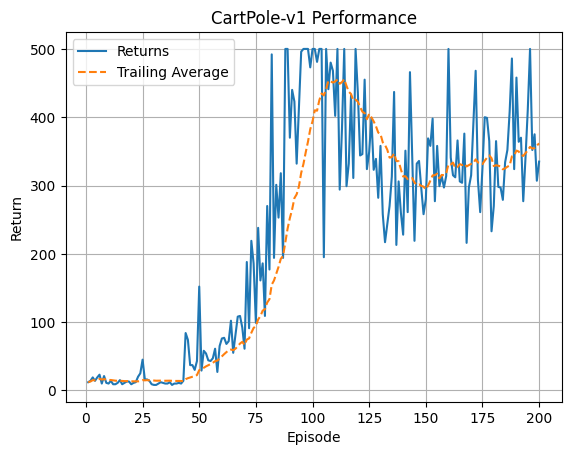

In [17]:
import matplotlib.pyplot as plt

plt.plot(episodes, returns, label='Returns')
plt.plot(episodes, trailing_avg_returns, label='Trailing Average', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('CartPole-v1 Performance')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
import argparse
args = argparse.Namespace(
    env='CartPole-v1',
    evaluate_freq=2,
    evaluation_episodes=1000
)

In [3]:
def evaluate_policy(agent, env, env_config, args, n_episodes, render=False, verbose=False):
    """Runs {n_episodes} episodes to evaluate current policy."""
    total_return = 0
    for i in range(n_episodes):
        state = env.reset()
        #state = preprocess(obs, env=args.env).unsqueeze(0)

        terminated = False
        episode_return = 0
        truncated = False
        while not terminated and not truncated:
            if render:
                env.render()

            action = agent.act(state, exploit=True)
            state, reward, terminated, truncated = env.step(action)
            #obs = preprocess(obs, env=args.env).unsqueeze(0)

            episode_return += reward

        total_return += episode_return

        if verbose:
            print(f'Finished episode {i+1} with a total return of {episode_return}')


    return total_return / n_episodes